In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    roc_curve, auc, confusion_matrix
)
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

## 將原始資料集轉換成預測要用的形式

In [14]:
data = pd.read_csv('a.csv', encoding='utf-8', encoding_errors='ignore')
data['E/I'] = data['type'].str[0]
data['S/N'] = data['type'].str[1]
data['T/F'] = data['type'].str[2]
data['J/P'] = data['type'].str[3]
data = data.drop(['type', 'posts'], axis=1)
data

,std_words,vocab_richness,avg_words,avg_sentences,avg_question_marks,avg_exclamation_marks,avg_ellipsis,avg_tilde,avg_dash,avg_links,...,disgust,fear,joy,sadness,surprise,trust,E/I,S/N,T/F,J/P
0,12.036950,0.575704,13.74,0.88,0.04,0.06,0.30,0.02,0.04,0.48,...,0,0,0,0,0,0,I,N,F,J
1,14.052380,0.409322,28.70,2.16,0.08,0.00,0.38,0.00,0.04,0.18,...,1,1,0,2,1,2,E,N,T,P
2,13.672556,0.488010,20.90,1.18,0.18,0.08,0.26,0.00,0.24,0.10,...,0,0,0,0,0,0,I,N,T,P
3,13.668510,0.422406,26.80,2.00,0.18,0.06,0.52,0.00,0.08,0.04,...,0,0,0,0,0,0,I,N,T,J
4,14.308553,0.446339,23.74,1.90,0.16,0.02,0.42,0.00,0.14,0.12,...,0,0,0,0,0,0,E,N,T,J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,11.443365,0.456522,19.74,1.16,0.10,0.12,0.14,0.00,0.02,0.14,...,0,0,0,0,0,0,I,S,F,P
8671,11.347282,0.352018,34.34,2.32,0.20,0.66,0.82,0.00,0.42,0.04,...,0,0,1,1,1,1,E,N,F,P
8672,13.186651,0.469008,24.12,2.06,0.14,0.02,0.38,0.00,0.14,0.04,...,0,0,0,1,0,1,I,N,T,P
8673,7.628732,0.334491,41.70,2.12,0.18,0.06,0.94,0.00,0.20,0.00,...,1,1,0,1,1,1,I,N,F,P


#### E/I

d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


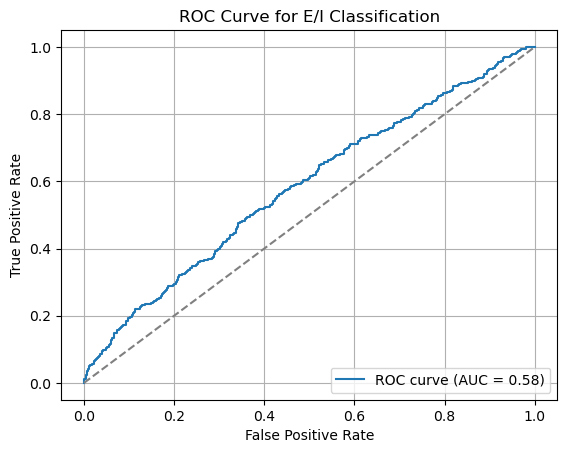

Accuracy: 0.5688760806916426
F1 Score: 0.37037037037037035
Confusion Matrix:
 [[220 180]
 [568 767]]

Classification Report:
               precision    recall  f1-score   support

           E       0.28      0.55      0.37       400
           I       0.81      0.57      0.67      1335

    accuracy                           0.57      1735
   macro avg       0.54      0.56      0.52      1735
weighted avg       0.69      0.57      0.60      1735



In [25]:
# feature: 所有欄位除了 MBTI 四維
feature_cols = [col for col in data.columns if col not in ['E/I', 'S/N', 'T/F', 'J/P', 'Unnamed: 0']]
X = data[feature_cols]
y = data['E/I']  # 你要預測的類別標籤

# === 拆分資料（80% train / 20% test）===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ 新增：使用 SMOTE 進行上採樣
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# === 建立 Logistic Regression 模型並訓練 ===
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# === 預測與評估 ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 0]  # 取得 'E' 類別的機率

# 評估指標
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='E')
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# === 繪製 ROC 曲線 ===
# 將 label 轉為二進位格式（'E'=1, 'I'=0）
y_test_binary = y_test.map({'I': 0, 'E': 1})
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for E/I Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# === 輸出結果 ===
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

In [20]:
print(model.classes_) 

['E' 'I']


#### S/N

d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


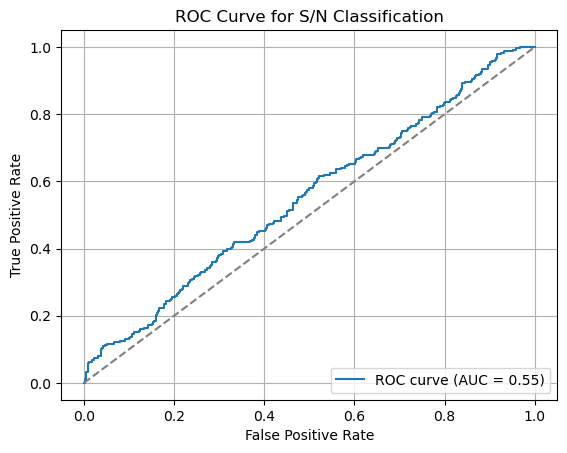

Accuracy: 0.5360230547550432
F1 Score: 0.2340627973358706
Confusion Matrix:
 [[807 689]
 [116 123]]

Classification Report:
               precision    recall  f1-score   support

           N       0.87      0.54      0.67      1496
           S       0.15      0.51      0.23       239

    accuracy                           0.54      1735
   macro avg       0.51      0.53      0.45      1735
weighted avg       0.77      0.54      0.61      1735



In [32]:
y = data['S/N']  # 你要預測的類別標籤

# === 拆分資料（80% train / 20% test）===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ 新增：使用 SMOTE 進行上採樣
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# === 建立 Logistic Regression 模型並訓練 ===
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# === 預測與評估 ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  

# 評估指標
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='S')
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# === 繪製 ROC 曲線 ===
y_test_binary = y_test.map({'N': 0, 'S': 1})
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for S/N Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# === 輸出結果 ===
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

In [30]:
print(model.classes_) 


['N' 'S']


#### T/F

d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


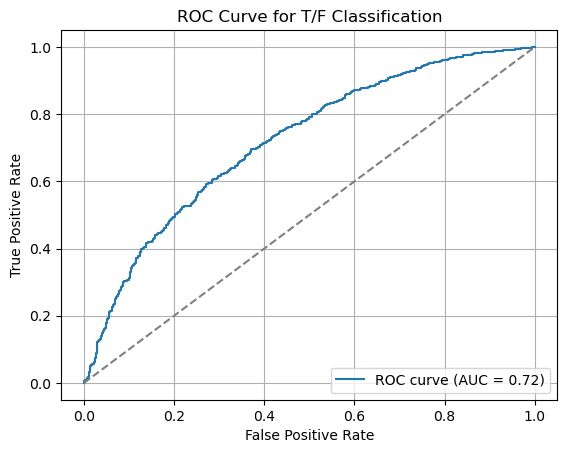

Accuracy: 0.652449567723343
F1 Score: 0.6536473291211947
Confusion Matrix:
 [[563 376]
 [227 569]]

Classification Report:
               precision    recall  f1-score   support

           F       0.71      0.60      0.65       939
           T       0.60      0.71      0.65       796

    accuracy                           0.65      1735
   macro avg       0.66      0.66      0.65      1735
weighted avg       0.66      0.65      0.65      1735



In [46]:
y = data['T/F']  # 你要預測的類別標籤

# === 拆分資料（80% train / 20% test）===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ 新增：使用 SMOTE 進行上採樣
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# === 建立 Logistic Regression 模型並訓練 ===
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# === 預測與評估 ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  

# 評估指標
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='T')
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# === 繪製 ROC 曲線 ===
y_test_binary = y_test.map({'F': 0, 'T': 1})
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for T/F Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# === 輸出結果 ===
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

In [34]:
print(model.classes_) 

['F' 'T']


#### J/P

d:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


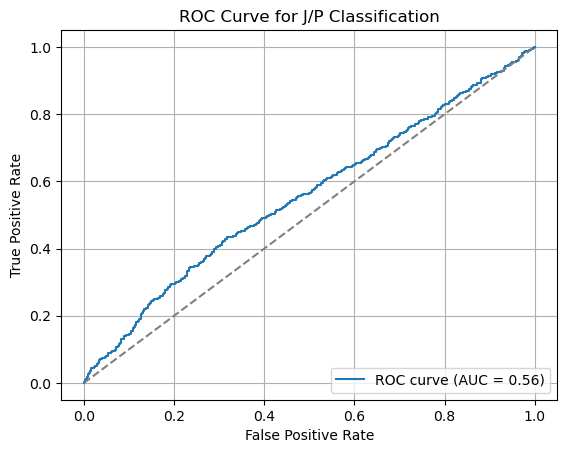

Accuracy: 0.5360230547550432
F1 Score: 0.4816484224082421
Confusion Matrix:
 [[374 313]
 [492 556]]

Classification Report:
               precision    recall  f1-score   support

           J       0.43      0.54      0.48       687
           P       0.64      0.53      0.58      1048

    accuracy                           0.54      1735
   macro avg       0.54      0.54      0.53      1735
weighted avg       0.56      0.54      0.54      1735



In [43]:
y = data['J/P']  # 你要預測的類別標籤

# === 拆分資料（80% train / 20% test）===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ 新增：使用 SMOTE 進行上採樣
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# === 建立 Logistic Regression 模型並訓練 ===
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# === 預測與評估 ===
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 0]  

# 評估指標
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label='J')
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# === 繪製 ROC 曲線 ===
y_test_binary = y_test.map({'J': 1, 'P': 0})
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for J/P Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# === 輸出結果 ===
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

In [44]:
print(model.classes_) 

['J' 'P']
